In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import ldspec
import zipfile

# autoreload
%load_ext autoreload
%autoreload 2

### Load data

In [2]:
DATA_PATH = "/n/groups/price/martin/LDSPEC_data/"
sumstats_file = '/n/groups/price/martin/LDSPEC_data/UKBimp_ss50K_MAF001_chimp/sumstats/@.sumstats.gz'
sumstats_full_file = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/sumstats/@.sumstats.gz'
trait_list = pd.read_csv(
    '/n/groups/price/martin/LDSPEC_data/UKBB_trait_ss50K/trait_list_all_indpt.txt', header=None,
)[0].to_list()

# genotype files
pgen_file = '/n/scratch/users/j/jz286/imp_geno_ss50K_chimp/ukb_imp_chr@_v3_chimp'
dic_data = {}
for CHR in range(1, 23):  # Check all 23 CHRs
    if os.path.exists(pgen_file.replace("@", "%s" % CHR) + ".pgen"):
        dic_data[CHR] = ldspec.util.read_pgen(
            pgen_file.replace("@", "%s" % CHR)
        )
ld_file = '/n/scratch/users/j/jz286/imp_geno_ss50K_chimp.ldspec_ld_1e6/ukb_imp_v3_chimp.@_ld.npz'
snp_range_list = pd.read_csv(
    '/n/groups/price/martin/LDSPEC_data/UKBimp_ss50K_MAF001_chimp/ukb_imp_v3.snp_range.txt', header=None,
)[0].to_list()

### Testing 

In [3]:
trait = 'body_HEIGHTz'
df_sumstats = pd.read_csv(sumstats_file.replace('@', trait), sep="\t", index_col=None)
df_sumstats_full = pd.read_csv(sumstats_full_file.replace('@', trait), sep="\t", index_col=None)

In [4]:
CHR = 22

# df_snp_chr
df_snp_chr = dic_data[CHR]['pvar'].copy()
df_snp_chr.index = df_snp_chr['SNP']
temp_dic = {x:y for x,y in zip(dic_data[CHR]['afreq']['SNP'],dic_data[CHR]['afreq']['MAF'])}
df_snp_chr['AF'] = [temp_dic[x] if x in temp_dic else 0 for x in df_snp_chr['SNP']]
temp_dic = {x:y for x,y in zip(df_sumstats['SNP'],df_sumstats['Z'])}
df_snp_chr['Z'] = [temp_dic[x] if x in temp_dic else 0 for x in df_snp_chr['SNP']]
df_snp_chr['P'] = ldspec.util.zsc2pval(df_snp_chr['Z'])
temp_dic = {x:y for x,y in zip(df_sumstats_full['SNP'],df_sumstats_full['Z'])}
df_snp_chr['Z_full'] = [temp_dic[x] if x in temp_dic else 0 for x in df_snp_chr['SNP']]
df_snp_chr['P_full'] = ldspec.util.zsc2pval(df_snp_chr['Z_full'])
df_snp_chr['idx'] = np.arange(df_snp_chr.shape[0])

# mat_ld
temp_list = [x for x in snp_range_list if x.startswith('c%d'%CHR)]
mat_ld_list = []
for snp_range in temp_list:
    mat_ld, dic_range = ldspec.util.read_ld(ld_file.replace('@', snp_range))
    mat_ld_list.append(mat_ld)
mat_ld_chr = sp.sparse.hstack(mat_ld_list)
del mat_ld_list

In [27]:
# baseline method 
v_sig = df_snp_chr['P']<5e-6
df_snp_chr.loc[v_sig]

,CHR,BP,SNP,REF,ALT,AF,Z,P,Z_full,P_full,idx
35364,22,23867761,rs147354058,G,C,0.007696,4.783067,1.726408e-06,2.591282,9.561918e-03,35364
87324,22,33048408,22:33048408_AAAACAAAGAAACAAAGTTTCTTTGTTGG_A,A,AAAACAAAGAAACAAAGTTTCTTTGTTGG,0.870867,4.985494,6.180370e-07,9.156319,5.369775e-20,87324
129918,22,40448476,rs550109265,T,G,0.997943,4.843799,1.273798e-06,1.953667,5.074061e-02,129918
129938,22,40453242,rs138408073,A,AT,0.001518,-4.588855,4.456839e-06,-2.016387,4.375956e-02,129938
129963,22,40457644,rs199909323,C,CTAAG,0.001452,-4.590146,4.429350e-06,-2.054620,3.991569e-02,129963
130018,22,40470782,rs559591151,C,CA,0.001377,-4.843328,1.276826e-06,-2.264788,2.352568e-02,130018
130021,22,40470808,rs533683496,T,G,0.998629,4.932724,8.109070e-07,2.044119,4.094175e-02,130021
130055,22,40475575,rs536120086,G,GTATATA,0.001268,-4.646718,3.372569e-06,-2.280776,2.256168e-02,130055
130099,22,40483171,22:40483171_CATT_C,C,CATT,0.998558,4.568533,4.911497e-06,2.079091,3.760899e-02,130099


In [53]:
# joint method
winsize = 1e5
rho_r_ratio = -0.2 
snp1 = 'rs147354058'
start_pos,end_pos = df_snp_chr.loc[snp1, 'BP']-0.501*winsize,df_snp_chr.loc[snp1, 'BP']+0.501*winsize
df_snp_locus = df_snp_chr.loc[(df_snp_chr['BP']>start_pos) & (df_snp_chr['BP']<end_pos)].copy()
df_snp_locus['idx_locus'] = np.arange(df_snp_locus.shape[0])
mat_ld_locus = mat_ld_chr[:, df_snp_locus['idx']][df_snp_locus['idx'], :].todense()
mat_ld_locus = np.array(mat_ld_locus)

In [56]:
idx1 = df_snp_locus.loc[snp1, 'idx_locus']
Z1 = df_snp_locus['Z'][idx1]

stat_list = []
for idx2 in range(df_snp_locus.shape[0]):    
    Z2 = df_snp_locus['Z'][idx2]
    r = mat_ld_locus[idx1,idx2]
    sigma_11 = 1+r**2+2*r**2*rho_r_ratio
    sigma_12 = 2*r+(1+r**2)*r*rho_r_ratio
    stat = sigma_11*Z1**2 + 2*sigma_12*Z1*Z2 + sigma_11*Z2**2
    stat_list.append(stat)

df_snp_locus['stat'] = stat_list
df_snp_locus['stat'].max()

145.8251836837702

In [ ]:
# null distribution 

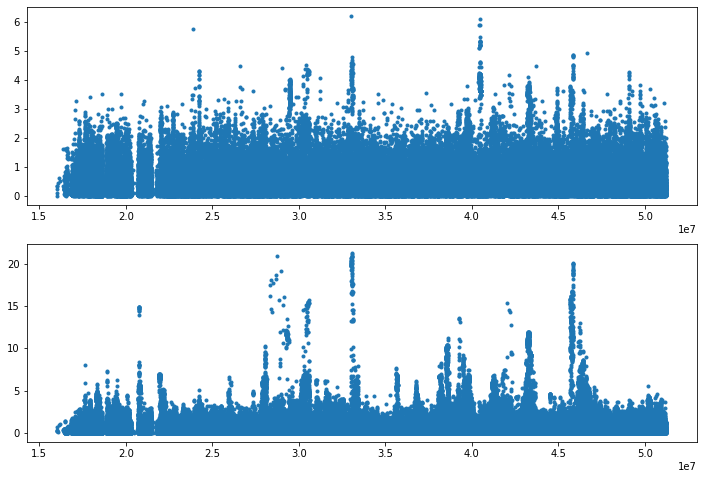

In [17]:
plt.figure(figsize=[12,8])
plt.subplot(2,1,1)
plt.plot(df_snp_chr['BP'], -np.log10(df_snp_chr['P']), '.')
plt.subplot(2,1,2)
plt.plot(df_snp_chr['BP'], -np.log10(df_snp_chr['P_full']), '.')
plt.show()

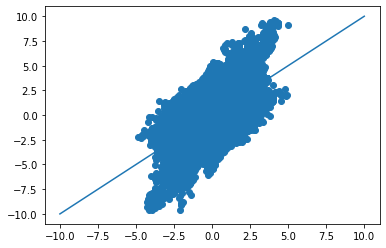

In [19]:
plt.figure()
plt.scatter(df_snp_chr['Z'], df_snp_chr['Z_full'])
plt.plot([-10, 10], [-10, 10])
plt.show()

In [24]:
temp_df1 = pd.read_csv(
    '/n/groups/price/martin/LDSPEC_data/UKBB_trait_ss50K/%s.resid.phen'%trait, sep='\t'
)
temp_df2 = pd.read_csv(
    '/n/groups/price/martin/LDSPEC_data/UKBB_trait/%s.resid.phen'%trait, sep='\t'
)
temp_df2.index = temp_df2['FID']

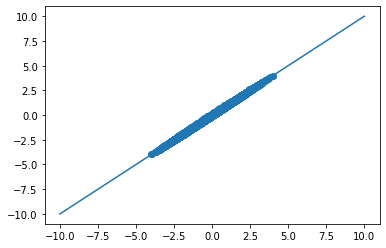

In [25]:
plt.figure()
plt.scatter(temp_df1[trait], temp_df2.loc[temp_df1['FID'], trait])
plt.plot([-10, 10], [-10, 10])
plt.show()

In [21]:
temp_df1

,FID,IID,body_HEIGHTz
0,1000019,1000019,-1.239240
1,1000248,1000248,1.729701
2,1000660,1000660,-0.906414
3,1000728,1000728,-0.521353
4,1000745,1000745,0.298696
...,...,...,...
50257,6025694,6025694,-1.838721
50258,6026178,6026178,1.307470
50259,6026223,6026223,0.988216
50260,6026285,6026285,-1.500540


In [23]:
temp_df2

,FID,IID,body_HEIGHTz
0,1000019,1000019,-1.279537
1,1000022,1000022,0.748824
2,1000035,1000035,0.406830
3,1000046,1000046,0.048864
4,1000063,1000063,-0.584544
...,...,...,...
336689,6026511,6026511,0.748977
336690,6026525,6026525,0.724669
336691,6026538,6026538,1.460428
336692,6026542,6026542,-0.733147


In [11]:
df_snp_chraa

,CHR,BP,SNP,REF,ALT,AF,Z,P,Z_full,P_full,idx
0,22,16050527,rs587769434,C,A,0.001524,0.000000,1.000000,0.809477,0.418241,0
1,22,16051249,rs62224609,T,C,0.100821,-0.751699,0.452232,0.484428,0.628082,1
2,22,16053862,rs62224614,C,T,0.102367,-0.551750,0.581120,0.497480,0.618850,2
3,22,16054454,rs7286962,C,T,0.105372,-0.717467,0.473086,0.434151,0.664179,3
4,22,16056406,22:16056406_C_T,C,T,0.001359,0.234323,0.814734,-1.278150,0.201197,4
...,...,...,...,...,...,...,...,...,...,...,...
199300,22,51237712,rs370652263,G,A,0.055291,1.389840,0.164578,0.526435,0.598586,199300
199301,22,51238318,rs541098394,A,T,0.003679,-1.341369,0.179801,0.829397,0.406880,199301
199302,22,51238328,rs553081191,A,C,0.001905,0.339080,0.734550,-0.601030,0.547820,199302
199303,22,51238394,rs149712012,C,T,0.003772,0.491421,0.623128,0.802659,0.422172,199303


In [56]:
1402714830 * 4 / 1e6

5610.85932